!apt is a linux command that instals new software on a computer. After updating!apt, install the openjdk-8-jdk-headless package.

In [2]:
!apt update > /dev/null
!apt install openjdk-8-jdk-headless -qq > /dev/null

First, install Spark with the!wget command. It will be installed as a tgz file, which is a linux zip file format, and it will be unzipped using!tar, which is a linux unzip application. Then install pyspark, which allows you to use python to access spark.

In [3]:
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [4]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()
from pyspark.conf import SparkConf
from pyspark import SparkContext

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

Using the!wget command to download the data from my github repository, where the dataset is stored.

In [7]:
!wget -q https://raw.githubusercontent.com/Dhrubajyoti87/turbine_power_prediction/main/wind_data.csv

In [8]:
ls

drive/                      spark-3.1.2-bin-hadoop3.2.tgz    wind_data.csv.1
sample_data/                spark-3.1.2-bin-hadoop3.2.tgz.1
spark-3.1.2-bin-hadoop3.2/  wind_data.csv


**Importing Libraries**

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

With the spark read csv command, I read a CSV file and saved it to a variable called df.

In [10]:
df = spark.read.csv('/content/wind_data.csv', header=True, inferSchema=True)

Converting all the column names to lower case

In [11]:
df = df.toDF(*[c.lower() for c in df.columns])

In a spark dataframe, the top 5 rows of the loaded data are shown.

In [12]:
print(df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None


The number of rows and columns is counted. There are 50530 rows and 5 columns in all.

In [13]:
print((df.count(),len(df.columns)))

(50530, 5)


Schema is a term used to describe the structure of a dataframe. This command also displays each column's data types.

In [14]:
df.printSchema()

root
 |-- date/time: string (nullable = true)
 |-- lv activepower (kw): double (nullable = true)
 |-- wind speed (m/s): double (nullable = true)
 |-- theoretical_power_curve (kwh): double (nullable = true)
 |-- wind direction (°): double (nullable = true)



The Describe function returns a five-point statistical overview of the loaded datset's numerical columns, such as count, mean, standard deviation, minimum range, and maximum range.

In [15]:
df.describe().show()

+-------+----------------+-------------------+-----------------+-----------------------------+------------------+
|summary|       date/time|lv activepower (kw)| wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+-------+----------------+-------------------+-----------------+-----------------------------+------------------+
|  count|           50530|              50530|            50530|                        50530|             50530|
|   mean|            null| 1307.6843318793121|7.557952236083209|           1492.1754629583377|123.68755850939199|
| stddev|            null| 1312.4592421268117|4.227166055611553|           1368.0182378726681| 93.44373572772585|
|    min|01 01 2018 00:00|  -2.47140502929687|              0.0|                          0.0|               0.0|
|    max|31 12 2018 23:50|   3618.73291015625| 25.2060108184814|                       3600.0|  359.997589111328|
+-------+----------------+-------------------+-----------------+------------------------

Creating Month and Hour Columns for further calculation and exploration of the dataset.

In [16]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
df = df.withColumn("month", substring("date/time", 4,2))
df = df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
df = df.withColumn('month', df.month.cast(IntegerType()))
df = df.withColumn('hour', df.hour.cast(IntegerType()))

print(df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

# **EDA**

Distribution of Wind Speed.

Text(0.5, 1.0, 'Distribution of Wind Speed')

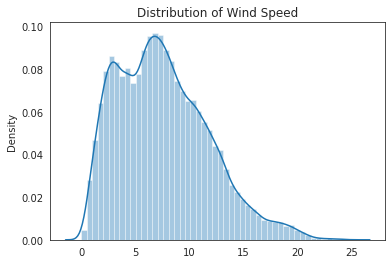

In [17]:
df_plot = df.select(['wind speed (m/s)']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Wind Speed')

Distribution of Wind Direction

Text(0.5, 1.0, 'Distribution of Wind Direction')

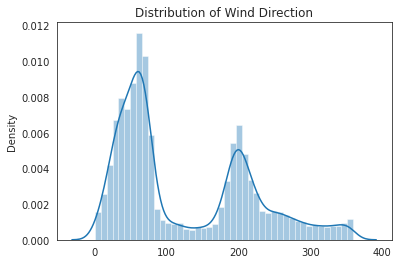

In [18]:
df_plot = df.select(['wind direction (°)']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Wind Direction')

Distribution of lv Active Power.

Text(0.5, 1.0, 'Distribution of lv Active Power')

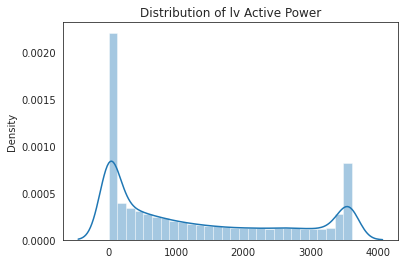

In [19]:
df_plot = df.select(['lv activepower (kw)']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of lv Active Power')

Distribution of Theoretical Power.

Text(0.5, 1.0, 'Distribution of Theoretical Power')

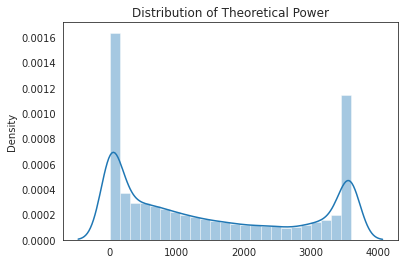

In [20]:
df_plot = df.select(['theoretical_power_curve (kwh)']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Theoretical Power')

Plotting Monthly Average Power Production

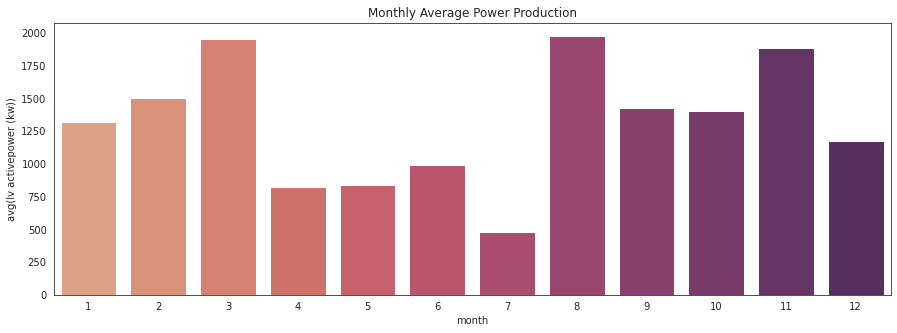

In [21]:
# Average power production by month
monthly = df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly, palette='flare')
plt.title('Monthly Average Power Production');

In March, August and November, the average power production is higher and in April, June, July and August is lower.

Plotting Hourly Average Power Production

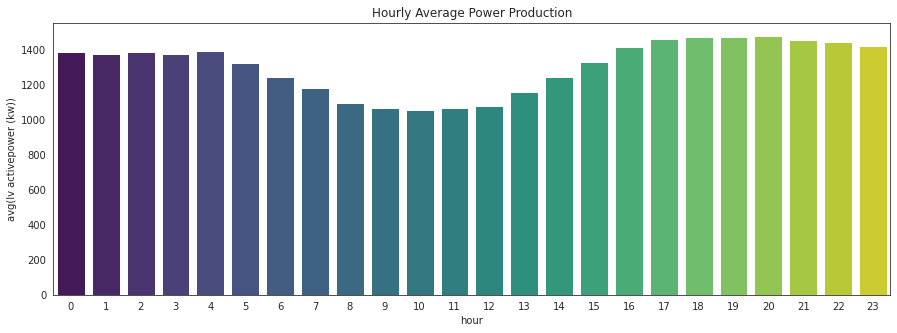

In [22]:
# Average power production by hour
hourly = df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
plt.figure(figsize=(15,5))
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly, palette='viridis')
plt.title('Hourly Average Power Production');

The average power production daily decays after 04:00 and start to increase after 12:00 and is higher  between 16:00 and 24:00.

Relation between the wind speed and power production by increasing wind speed by 5m/s

Text(0, 0.5, 'Average Power Production')

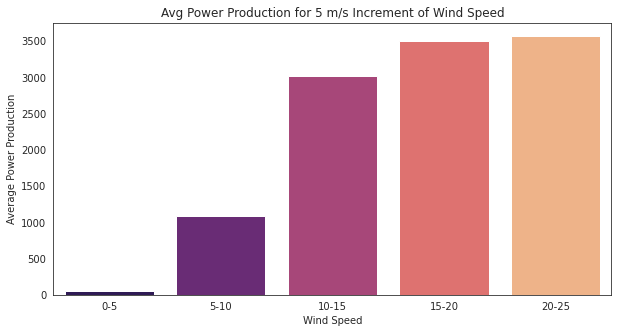

In [23]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = df.filter((df['wind speed (m/s)'] > i) 
                                & (df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))
plt.figure(figsize=(10,5))
sns.barplot(x=wind_speed, y=avg_power, palette='magma')
plt.title('Avg Power Production for 5 m/s Increment of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production')

From the graph above we can see the power production reaches near a maximum level after the wind speed reaches 15 m/s.

Boxplot for Wind Direction

Text(0.5, 1.0, 'Distribution of Wind Direction')

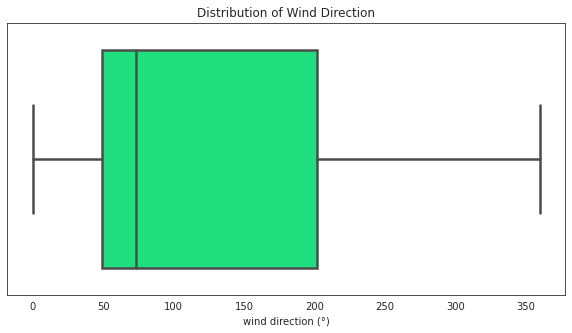

In [24]:
df_plot = df.select(['wind direction (°)']).toPandas()
plt.figure(figsize=(10,5))
sns.boxplot(df_plot['wind direction (°)'], color ='springgreen', linewidth=2.5, fliersize=2.5)
plt.title('Distribution of Wind Direction')

There are no outliers for Wind Direction.

Boxplot for Theoretical Power

Text(0.5, 1.0, 'Distribution of Theoretical_Power_Curve (kwh)')

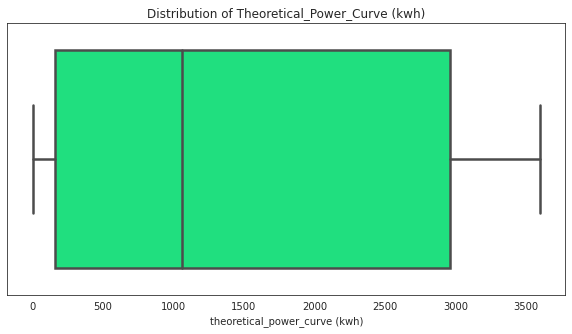

In [25]:
df_plot = df.select(['theoretical_power_curve (kwh)']).toPandas()
plt.figure(figsize=(10,5))
sns.boxplot(df_plot['theoretical_power_curve (kwh)'], color ='springgreen', linewidth=2.5, fliersize=2.5)
plt.title('Distribution of Theoretical_Power_Curve (kwh)')

There is no outlier for Theoretical Power.

Distribution for lv Active Power

Text(0.5, 1.0, 'Distribution of lv Activepower (kw)')

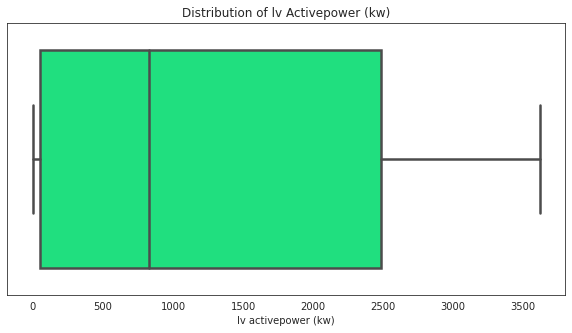

In [26]:
df_plot = df.select(['lv activepower (kw)']).toPandas()
plt.figure(figsize=(10,5))
sns.boxplot(df_plot['lv activepower (kw)'], color ='springgreen', linewidth=2.5, fliersize=2.5)
plt.title('Distribution of lv Activepower (kw)')

There is no outlier for lv Active Power

Boxplot for Wind Speed

Text(0.5, 1.0, 'Distribution of Wind Speed (m/s)')

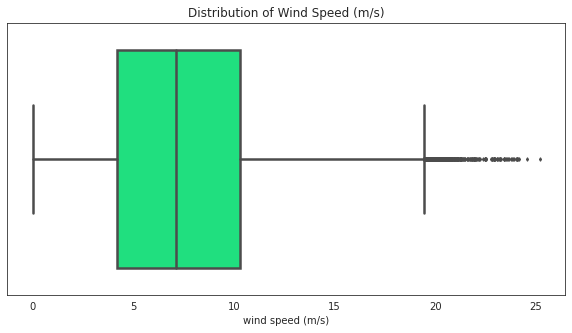

In [27]:
df_plot = df.select(['wind speed (m/s)']).toPandas()
plt.figure(figsize=(10,5))
sns.boxplot(df_plot['wind speed (m/s)'], color ='springgreen', linewidth=2.5, fliersize=2.5)
plt.title('Distribution of Wind Speed (m/s)')

There are some outliers for Wind Speed. Have to do outlier treatment in the next stage of data processing before applying Machine Learning model for prediction to increase model accuracy.

Correlation among the variables

In [28]:
df_corr = df.toPandas()
corr = df_corr.corr()
corr
#corr.style.background_gradient(cmap='YlGnBu')

,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
lv activepower (kw),1.000000,0.912774,0.949918,-0.062702,0.031010,0.036355
wind speed (m/s),0.912774,1.000000,0.944209,-0.077188,-0.013349,0.024754
theoretical_power_curve (kwh),0.949918,0.944209,1.000000,-0.099076,0.004455,0.034636
wind direction (°),-0.062702,-0.077188,-0.099076,1.000000,-0.180712,-0.015355
month,0.031010,-0.013349,0.004455,-0.180712,1.000000,0.001510
hour,0.036355,0.024754,0.034636,-0.015355,0.001510,1.000000


FInding where theoretical and real power production is zero

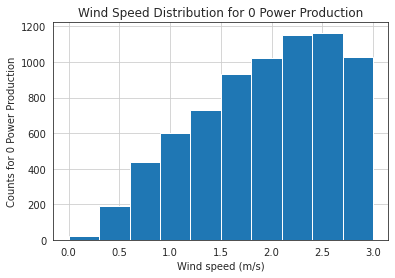

In [29]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = df.filter((df['lv activepower (kw)'] == 0)
                                  & (df['theoretical_power_curve (kwh)'] == 0)).toPandas()

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

The theoretical power curve has a limit of 3 m/s wind speed, as can be seen above. There is no power output if the wind speed is less than 3 m/s.

Observations for the wind speed > 3m/s and power production = 0

In [30]:
# While theoritically there should be power production
zero_power = df.filter((df['lv activepower (kw)'] == 0)
                            & (df['theoretical_power_curve (kwh)'] != 0)
                            & (df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.0,3.743307,83.986265,245.068207,1,15
1,03 01 2018 16:40,0.0,3.034003,17.180593,221.086502,1,16
2,03 01 2018 16:50,0.0,3.197354,25.431221,232.679596,1,16
3,03 01 2018 17:00,0.0,3.907811,110.979604,241.973099,1,17
4,04 01 2018 13:50,0.0,3.441704,45.742725,79.094109,1,13


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


There are 3497 observations where theoretically there should be power production

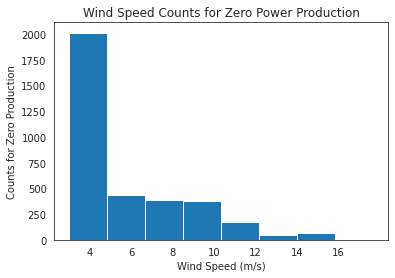

In [31]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

Theoretically, the wind speed barrier should be 4 m/s. However, there have been instances where no power is produced while the wind speed is higher.

Monthly distribution for zero power production

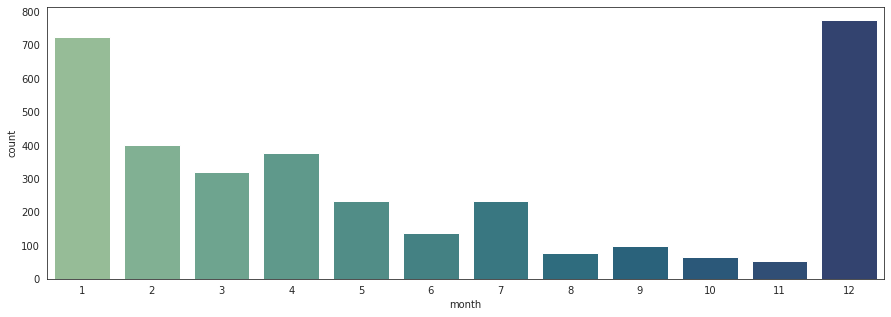

In [32]:
plt.figure(figsize=(15,5))
sns.countplot(zero_power['month'], palette='crest');

The wind turbine normally does not produce in the months of December and January.

Removing 3497 observations from tha dataset where windspeed is > 3 m/s but power production is zero as the reason for this observation is totally unknown.

In [33]:
df = df.filter(~((df['lv activepower (kw)'] == 0)
                            & (df['theoretical_power_curve (kwh)'] != 0)
                            & (df['wind speed (m/s)'] > 3)))

CHecking no of rows after removing those observations.

In [34]:
print((df.count(),len(df.columns)))

(47033, 7)


Plotting boxplot to check the outlier for wind speed again 

Text(0.5, 1.0, 'Distribution of Wind Speed (m/s)')

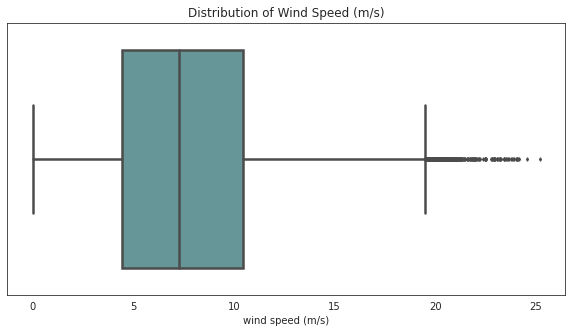

In [35]:
df_plot = df.select(['wind speed (m/s)']).toPandas()
plt.figure(figsize=(10,5))
sns.boxplot(df_plot['wind speed (m/s)'], color ='cadetblue', linewidth=2.5, fliersize=2.5)
plt.title('Distribution of Wind Speed (m/s)')

Still there are outliers which need to be treated for further analysis.

In [36]:
# Create a pandas df for visualization
wind_speed = df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Lower whisker: ', lower, ' Upper whisker: ', upper)

Lower whisker:  -4.576168060302599  Upper whisker:  19.50920486450172


FInding total no of outliers for wind speed

In [37]:
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))

Total Number of Outliers:  407


Treating the outliers with upper whisker value

In [38]:
from pyspark.sql import functions as F
df = df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.50, 19)
                               .otherwise(F.col('wind speed (m/s)')))

**Preparing Data for Machine Learning Algorithms**

Vector assembler is used to combine numerous columns into a vector column, which was then produced as a single feature column. All of the necessary columns have inputs.

In [39]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
df = df.withColumn('label', df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



To do machine learning model creation and verification, divide the data into training and test datasets.

In [40]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37840
Test dataset :  9193


**LInear Regression**

Linear Regression is a machine learning algorithm based on supervised learning. It performs a regression task. Regression models a target prediction value based on independent variables. It is mostly used for finding out the relationship between dependent  and independent variables.

For implementing the model from pyspark ml regression model imported the Linear Regression. Created an instance of that with mentioning the feature columns , label columns and model type.Fit the model into the train data and performed prediction with test data.

For evaluation of the performance of the model from pyspark ml evaluation imported the Regression Evaluator and measured the R2 score and RMSE.

In [41]:
from pyspark.ml.regression import LinearRegression
lr= LinearRegression(featuresCol = 'features', labelCol='label')
lr_model=lr.fit(train_df)
y_pred=lr_model.transform(test_df)
y_pred.select('label','prediction').show(10)

#evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|-355.9957650919537|
|320.979614257812|  580.471198781785|
|296.469909667968| 601.6748120122791|
|355.225006103515| 644.1379350578172|
| 429.36538696289| 697.4042712199832|
|402.391998291015| 761.0347595431808|
|639.275573730468| 824.0825490017196|
|685.547424316406| 860.9350382098112|
|1183.02099609375|1204.6208018270827|
|842.209289550781|1220.7700357498097|
+----------------+------------------+
only showing top 10 rows

R2 SCORE :  0.8885649287821278
RMSE     :  435.2652768367119


**Random Forest Regression**

Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.

For implementing the model from pyspark ml regression model imported the Random Forest regressor. Created a instance of that with mentioning the feature columns , label columns and model type.Fit the model into the train data and performed prediction with test data.

For evaluation of the performance of the model from pyspark ml evaluation imported the BRegreesion Evaluator and measured the R2 score and RMSE.

In [42]:
from pyspark.ml.regression import RandomForestRegressor
rf= RandomForestRegressor(featuresCol = 'features', labelCol='label')
rf_model=rf.fit(train_df)
y_pred=rf_model.transform(test_df)
y_pred.select('label','prediction').show(10)

#evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0| 169.9079267562143|
|320.979614257812|349.26826461148676|
|296.469909667968|349.26826461148676|
|355.225006103515| 360.2225607148378|
| 429.36538696289| 360.2225607148378|
|402.391998291015| 398.1036455126074|
|639.275573730468| 458.1529041567313|
|685.547424316406|506.05883342143414|
|1183.02099609375|1014.1620951515963|
|842.209289550781|1014.1620951515963|
+----------------+------------------+
only showing top 10 rows

R2 SCORE :  0.9690603065956375
RMSE     :  229.35123245330666
